In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from collections import defaultdict
from wordcloud import WordCloud
from joblib import parallel_backend

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Изучение, подготовка и очистка данных ##

In [ ]:
# Записываем предаставленные данные из Датасета голосового бота в переменную df
df = pd.read_csv('voice_bot_26_03_2024.csv')
df.head()

id                                     text                    datetime
0   2                      получение куар хода  2022-01-25 10:26:08.250148
1  20            потеряли код получения заказа  2022-01-25 11:15:12.752175
2  36                         получить посылку  2022-01-25 12:06:13.747782
3  50  мне не пришел код для получения посылки  2022-01-25 14:19:56.151572
4  64                   связаться с оператором  2022-01-25 14:41:44.752494

In [ ]:
# Основная информация о датасете
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699393 entries, 0 to 1699392
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        int64 
 1   text      object
 2   datetime  object
dtypes: int64(1), object(2)
memory usage: 38.9+ MB
None


In [ ]:
# Статистика только по столбцам типа object
print(df.describe(include=[object]))

                       text                    datetime
count               1699393                     1699393
unique               445789                     1699393
top     получить код выдачи  2022-01-25 10:26:08.250148
freq                 238178                           1


In [ ]:
# Проверка на пропущенные значения
print(df.isnull().sum())

id          0
text        0
datetime    0
dtype: int64


In [ ]:
# Удаляем лишние столбцы из dataframe
df = df.drop(columns=['datetime', 'id'])

In [ ]:
# Удаляем дубликаты
# Подсчитываем количество строк до удаления дубликатов
initial_count = len(df)

# Удаляем дубликаты из колонки 'text'
df = df.drop_duplicates(subset=['text'])

# Подсчитываем количество строк после удаления дубликатов
final_count = len(df)

# Вычисляем количество удаленных дубликатов
removed_duplicates_count = initial_count - final_count

# Печатаем информацию о количестве удаленных дубликатов
print("Количество строк в колонке 'text' до удаления:", initial_count)
print("Количество строк в колонке 'text' после удаления:", final_count)
print("Количество удаленных дубликатов из колонки 'text':", removed_duplicates_count)

Количество строк в колонке 'text' до удаления: 1699393
Количество строк в колонке 'text' после удаления: 445789
Количество удаленных дубликатов из колонки 'text': 1253604


In [ ]:
# Очистим датасет от знаков припенания и повторяющихся пробелов

# Функция для очистки текста от знаков препинания и повторяющихся пробелов, а также подсчета количества удаленных символов
def clean_text_and_count(text):
    # Удаление знаков препинания
    cleaned_text = ''.join([char for char in text if char not in string.punctuation])
    # Подсчет удаленных знаков препинания
    removed_punctuation = len(text) - len(cleaned_text)

    # Удаление повторяющихся пробелов
    cleaned_text_with_single_spaces = ' '.join(cleaned_text.split())
    # Подсчет удаленных пробелов
    removed_spaces = len(cleaned_text) - len(cleaned_text_with_single_spaces)

    # Общее количество удаленных символов
    total_removed_chars = removed_punctuation + removed_spaces

    return cleaned_text_with_single_spaces, total_removed_chars

# Применяем функцию к каждой строке столбца 'text'
results = df['text'].apply(clean_text_and_count)
df['text'] = results.apply(lambda x: x[0])
total_removed_chars = results.apply(lambda x: x[1]).sum()

# Печатаем информацию о количестве удаленных символов
print("Всего удалено символов:", total_removed_chars)

Всего удалено символов: 21


In [ ]:
# Приведение текста к нижнему регистру
df['text'] = df['text'].str.lower()

In [ ]:
# Посмортим на общее количество строк с менее чем 2 словами и что там за значения

# Фильтруем строки с менее чем 2 словами
short_rows = df[df['text'].str.split().apply(len) < 2]

# Выводим отфильтрованные строки на экран
print("Количество строк с менее чем 2 словами:", len(short_rows))
print("Каждое значение и количество его вхождений:")
print(short_rows['text'].value_counts())

Количество строк с менее чем 2 словами: 2738
Каждое значение и количество его вхождений:
text
оператор       1
звонила        1
стойте         1
задолбала      1
осталось       1
              ..
работаете      1
заказе         1
зовите         1
получакас      1
закончилось    1
Name: count, Length: 2738, dtype: int64


In [ ]:
# Убираем из df слишком длинные строки и сохраняем их в отдельный Датасет, чтобы присвоить им в будущем отдельный класс.

# Рассчитаем длины текстов
df['text_length'] = df['text'].apply(len)

# Рассчитаем квартильные значения
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Определим границы для удаления выбросов
upper_bound = Q3 + 1.5 * IQR

# Определяем выбросы
outliers = df[(df['text_length'] > upper_bound)]

# Сохраняем выбросы в CSV-файл
outliers.to_csv('outliers.csv', index=False)

# Удаляем выбросы из основного DataFrame
df_filtered = df[(df['text_length'] <= upper_bound)]

# Удалим временную колонку с длиной текста
df_filtered = df_filtered.drop(columns=['text_length'])

print("Количество строк до удаления выбросов:", len(df))
print("Количество строк после удаления выбросов:", len(df_filtered))
print("Всего удалено строк:", len(df) - len(df_filtered))
df = df_filtered

Количество строк до удаления выбросов: 445789
Количество строк после удаления выбросов: 409887
Всего удалено строк: 35902


## Обучение классификатора на основе Kmeans ##

In [ ]:
# Создание и применение TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=120000)
X = vectorizer.fit_transform(df['text'])

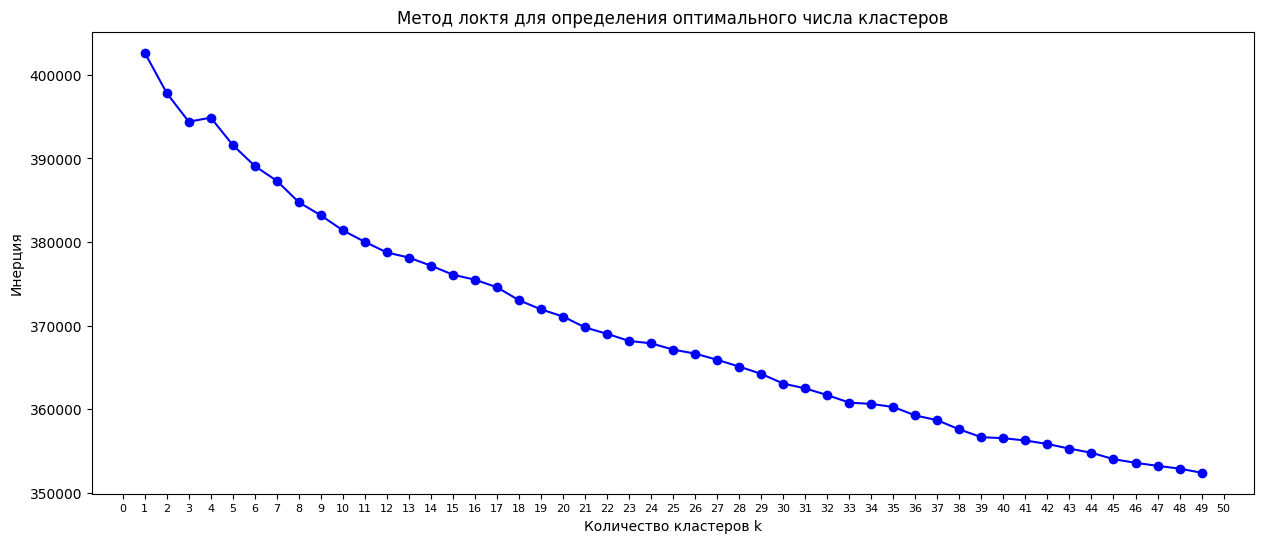

In [ ]:
# Используем метод локтя для определения оптимального количества кластеров

# Диапазон значений k для анализа
k_values = range(1, 50)
inertia_values = []

# Обучение модели KMeans для различных значений k и вычисление инерции
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(15, 6))
plt.plot(k_values, inertia_values, 'bo-')
# Увеличение количества меток на оси X
plt.xticks(range(0, 51, 1), fontsize=8)
plt.xlabel('Количество кластеров k')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.show()

In [ ]:
# Инициализация и обучение K-Means модели
num_clusters =  39
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
# Добавление меток кластеров в DataFrame
df['cluster_label'] = kmeans.labels_

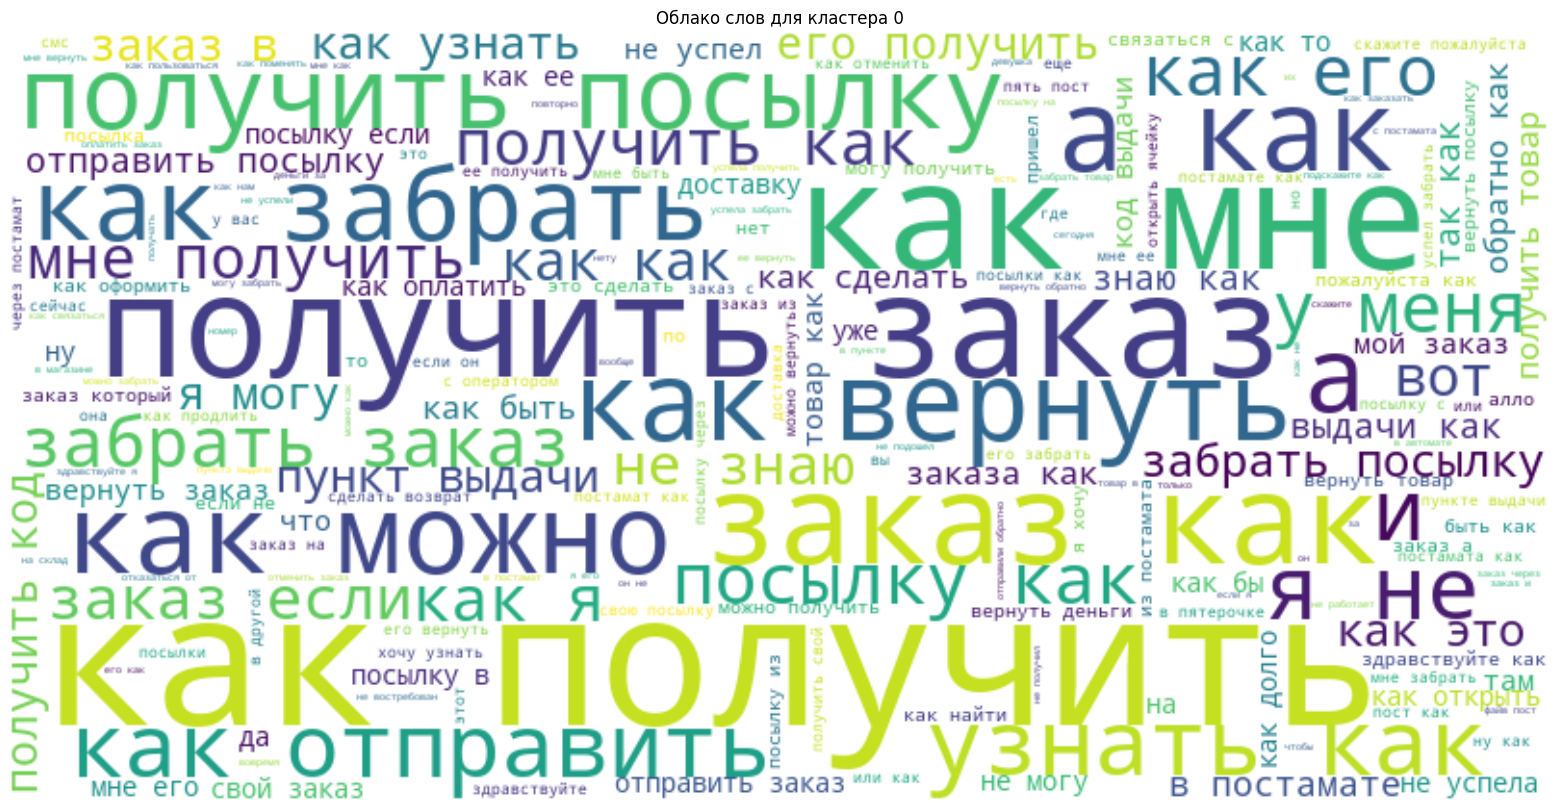

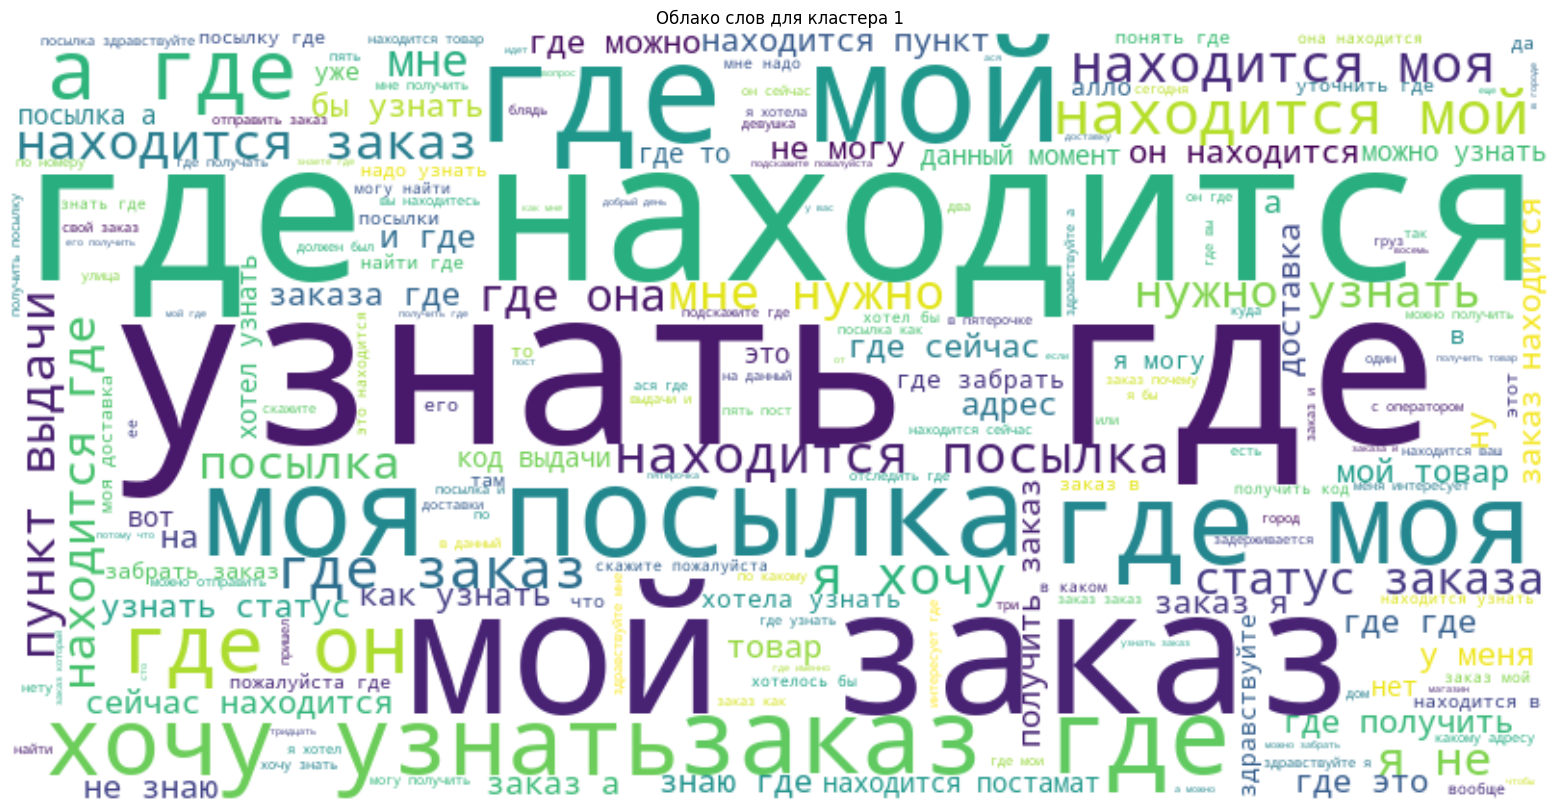

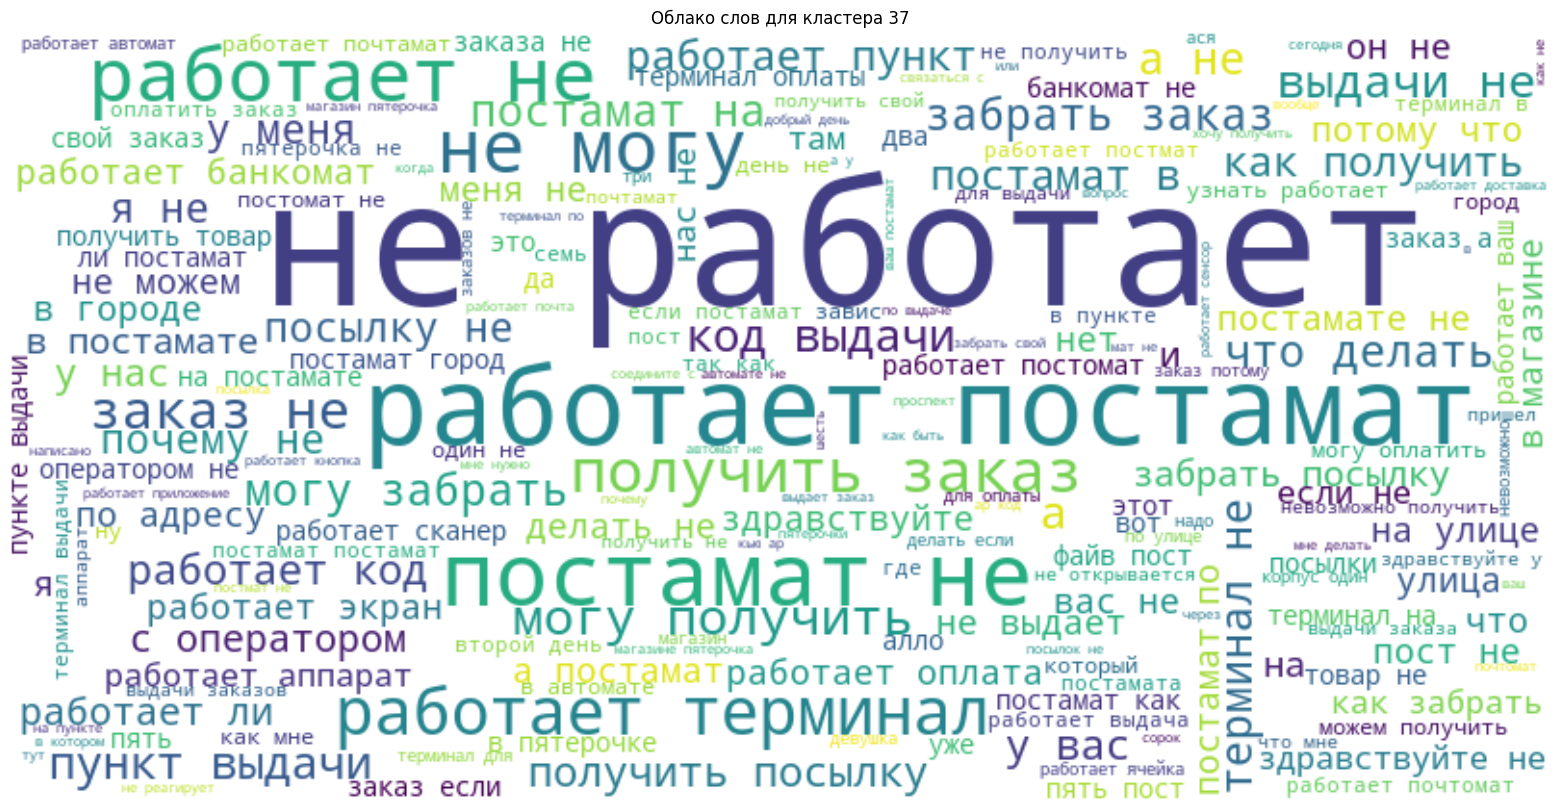

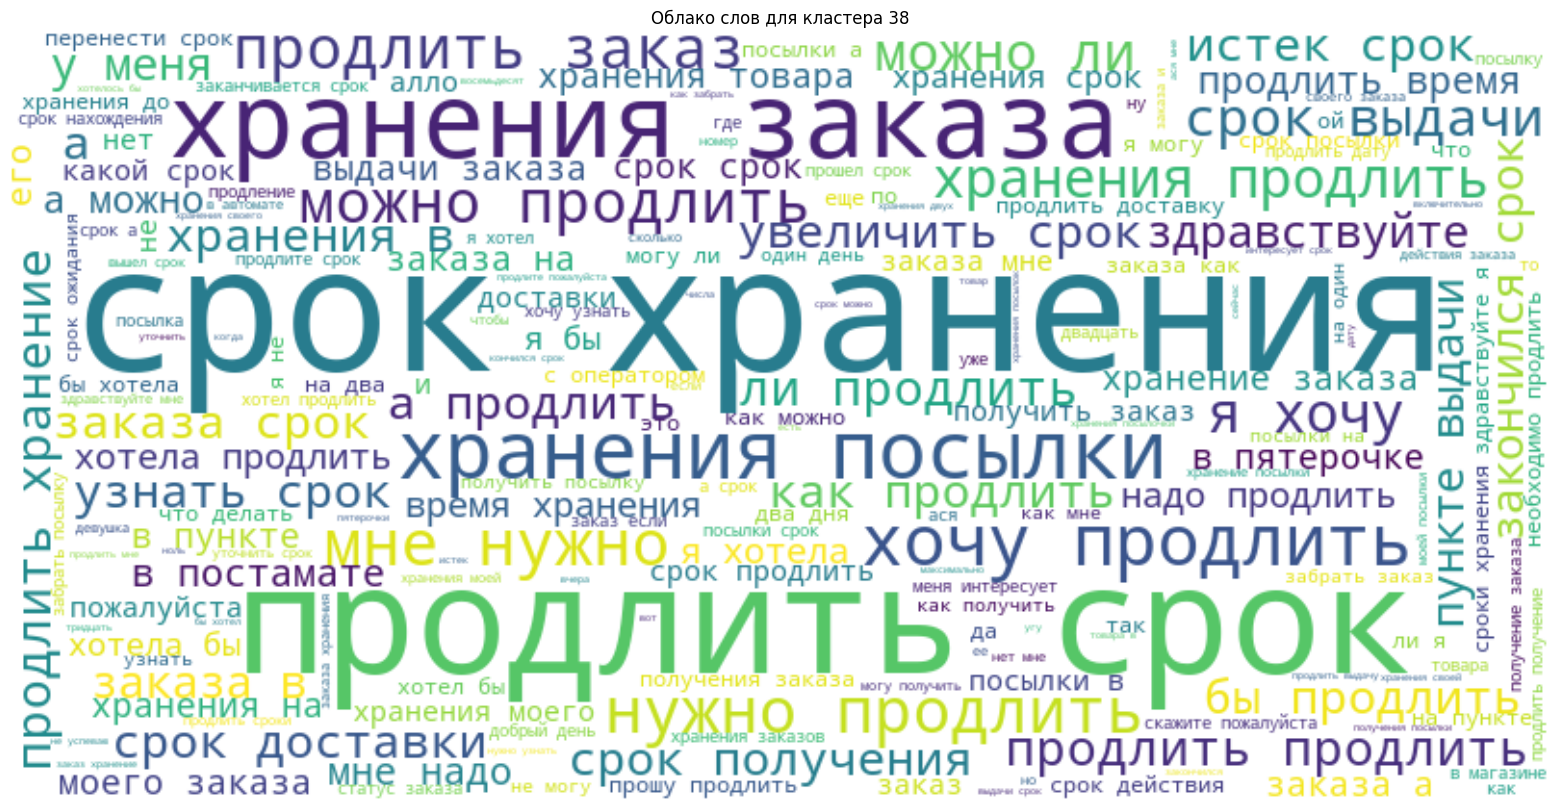

C:\Users\artem\AppData\Local\Temp\ipykernel_10984\3324800525.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq_dict.values()), y=list(word_freq_dict.keys()), palette='viridis')


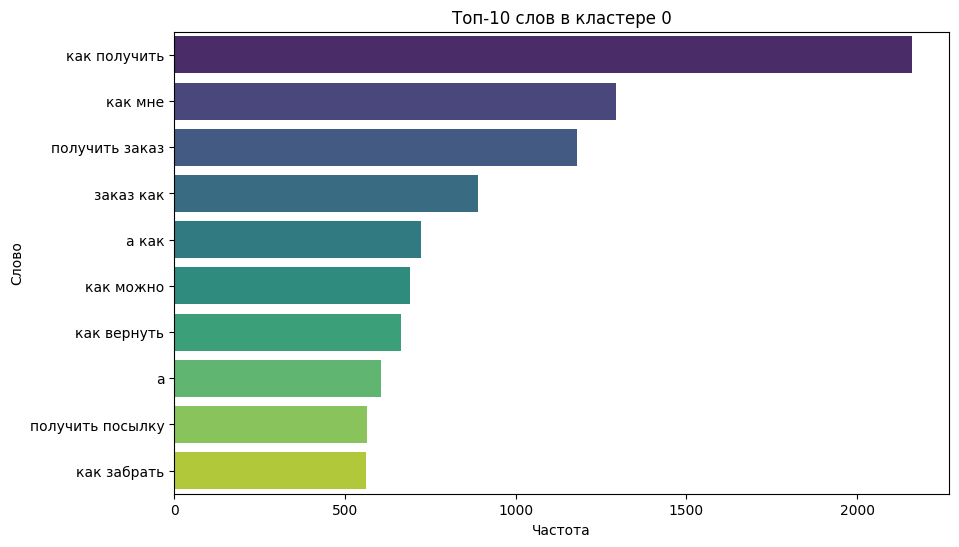

C:\Users\artem\AppData\Local\Temp\ipykernel_10984\3324800525.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq_dict.values()), y=list(word_freq_dict.keys()), palette='viridis')


C:\Users\artem\AppData\Local\Temp\ipykernel_10984\3324800525.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq_dict.values()), y=list(word_freq_dict.keys()), palette='viridis')


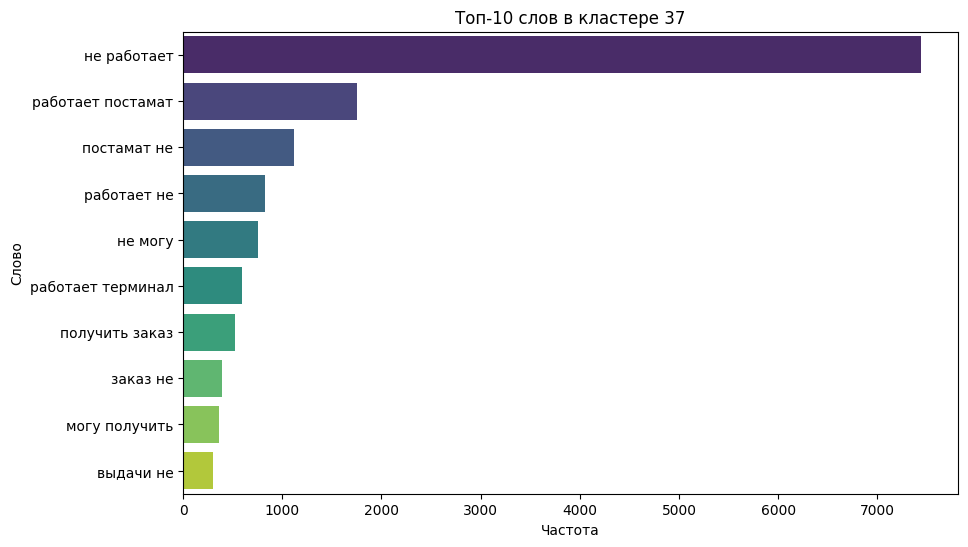

C:\Users\artem\AppData\Local\Temp\ipykernel_10984\3324800525.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq_dict.values()), y=list(word_freq_dict.keys()), palette='viridis')


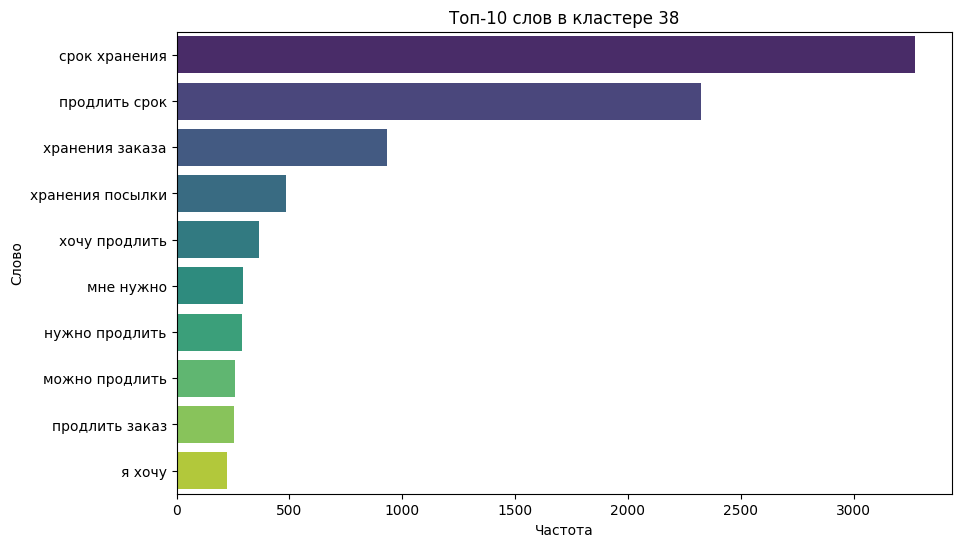

In [ ]:
# Генерация облака слов для кластеров
for i in range(num_clusters):
    # Объединение текста в кластере в одну строку
    cluster_text = " ".join(df[df['cluster_label'] == i]['text'])

    # Создание облака слов для кластера
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    # Отображение облака слов
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов для кластера {i}')
    plt.axis('off')  # Отключение осей координат
    plt.show()

# Генерация Word Clouds для кластеров
for i in range(num_clusters):
    # Объединение текста в кластере в одну строку
    cluster_text = " ".join(df[df['cluster_label'] == i]['text'])

    # Получение частоты встречаемости слов в кластере
    word_freq = WordCloud().process_text(cluster_text)
    # Получение топ-10 наиболее часто встречающихся слов в кластере
    word_freq_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    word_freq_dict = {word: freq for word, freq in word_freq_sorted}

    # Создание столбчатой диаграммы для топ-10 слов в кластере
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(word_freq_dict.values()), y=list(word_freq_dict.keys()), palette='viridis')
    plt.title(f'Топ-10 слов в кластере {i}')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.show()

    # Для примера оставлены только первые и последние изображения облаков и гистограмм

C:\Users\artem\AppData\Local\Temp\ipykernel_10984\173185397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['sub_cluster_label'] = sub_kmeans.labels_
C:\Users\artem\AppData\Local\Temp\ipykernel_10984\173185397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['sub_cluster_label'] = sub_kmeans.labels_
C:\Users\artem\AppData\Local\Temp\ipykernel_10984\173185397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

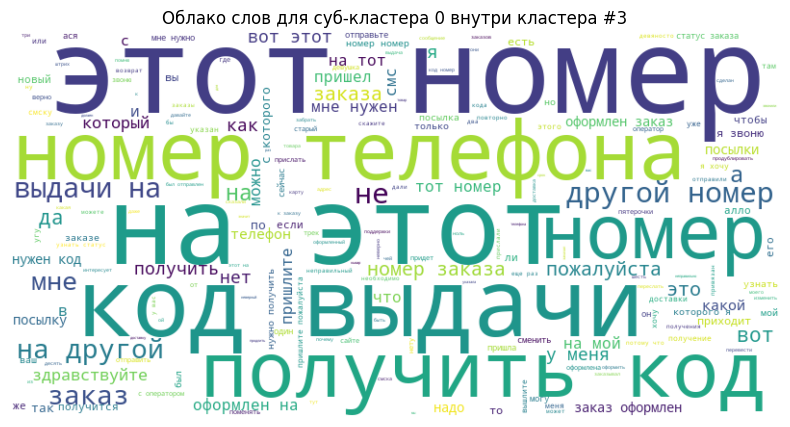

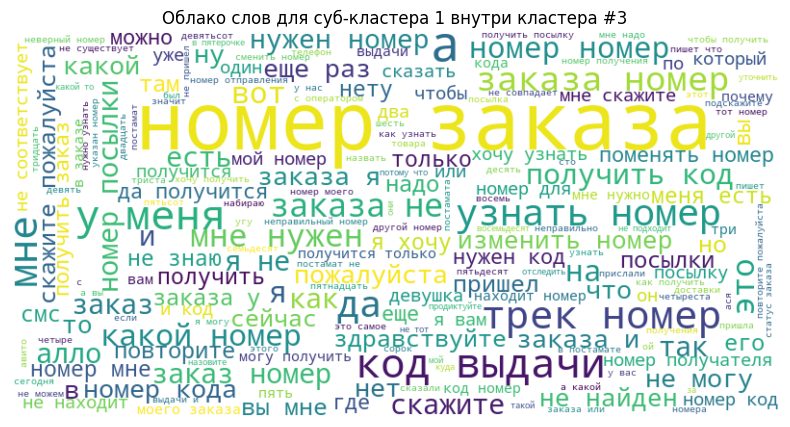

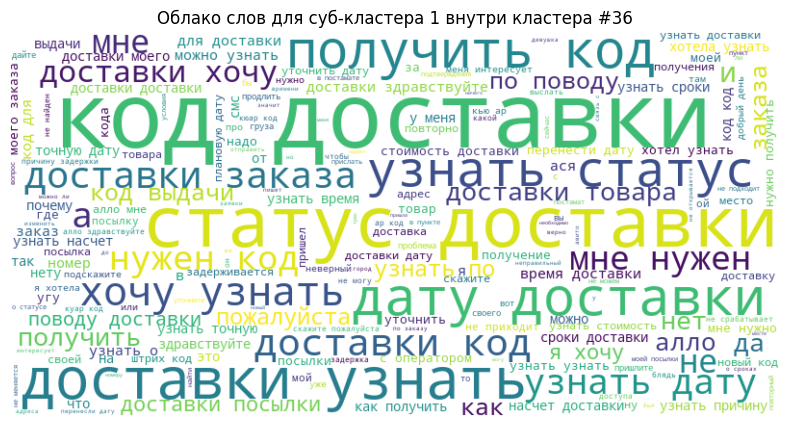

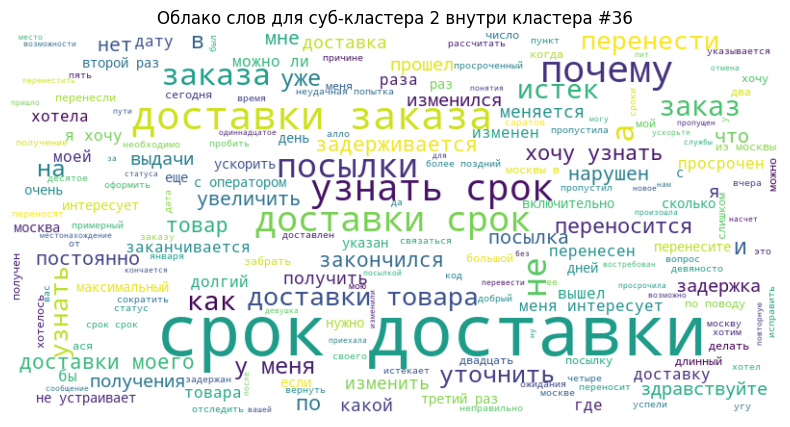

In [ ]:
# Этот блок используем если кластер требует дальнейшего разделения на подкластеры
cluster_ids = [3, 9, 10, 24, 25, 27, 29, 36] # указываем номера кластеров
num_sub_clusters = 3  # Количество субкластеров

for cluster_id in cluster_ids:
    # Получаем поднабор данных для текущего кластера
    cluster_df = df[df['cluster_label'] == cluster_id]
    # Инициализируем и обучаем модель KMeans для субкластеров
    sub_kmeans = KMeans(n_clusters=num_sub_clusters, random_state=42)
    sub_kmeans.fit(vectorizer.transform(cluster_df['text']))
    # Добавляем метки субкластеров в dataframe для текущего кластера
    cluster_df['sub_cluster_label'] = sub_kmeans.labels_
    df.loc[df['cluster_label'] == cluster_id, 'sub_cluster_label'] = cluster_df['sub_cluster_label']

# Анализ подкластеров внутри кластеров
cluster_ids = [3, 9, 10, 24, 25, 27, 29, 36] # указываем номера кластеров
for cluster_id in cluster_ids:
    # Получаем поднабор данных для текущего кластера
    cluster_df = df[df['cluster_label'] == cluster_id]
    # Анализируем подкластеры внутри текущего кластера
    for i in range(num_sub_clusters):
        # Получаем текст подкластера
        cluster_sub_text = " ".join(cluster_df[cluster_df['sub_cluster_label'] == i]['text'])
        # Создаем облако слов для подкластера
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_sub_text)

        # Отображаем облако слов для подкластера
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Облако слов для суб-кластера {i} внутри кластера #{cluster_id}')
        plt.axis('off')
        plt.show()

        # Для примера оставлены только первые и последние изображения облаков

In [ ]:
# Обучаем окончательную модель и сохраняем её
final_model = {
    'kmeans_model': kmeans,  # Основная модель KMeans
    'sub_kmeans_model': sub_kmeans,  # Вспомогательная модель KMeans (если есть)
    'vectorizer': vectorizer  # Векторизатор (например, TF-IDF или CountVectorizer)
}

In [ ]:
# Сохраняем окончательную модель в файл final_model.pkl с помощью модуля pickle
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Выводим сообщение о успешном обучении и сохранении окончательной модели
print("Окончательная модель обучена и успешно сохранена.")

Окончательная модель обучена и успешно сохранена.


In [ ]:
def predict_cluster(text, model_data):
    # Загружаем обученную модель
    with open('final_model.pkl', 'rb') as file:
        model_data = pickle.load(file)

    # Предварительная обработка текста
    text_vector = model_data['vectorizer'].transform([text])

    ## Предсказываем основной кластер
    main_cluster_label = model_data['kmeans_model'].predict(text_vector)[0]

    # Определение имени кластера и подкластера на основе метки основного кластера
    # Словарь с именами кластеров. Здесь идет нумерация кластеров с их описанием
    cluster_names = {
        0: "0: Получить информацию о заказе",
        1: "1: Местонахождение заказа",
        2: "2: Проблема с открытием ячейки",
        3: "3: ",
        4: "4: Код получения",
        5: "5: Получатель подтверждает, что заберёт заказ",
        6: "6: Получатель подтверждает, что заберёт заказ",
        7: "7: Проблема с получением",
        8: "8: Код получения",
        9: "9: ",
        10: "10: ",
        11: "11: Код получения",
        12: "12: Соедините с оператором",
        13: "13: Проблема с открытием ячейки",
        14: "14: Посылка не пришла",
        15: "15: Проблема с получением",
        16: "16: Адрес доставки",
        17: "17: Проблема с получением",
        18: "18: Проблема с получением",
        19: "19: Статус заказа",
        20: "20: Сотрудник магазина",
        21: "21: Соедините с оператором",
        22: "22: Соедините с оператором",
        23: "23: Получатель подтверждает, что заберёт заказ",
        24: "24: ",
        25: "25: ",
        26: "26: Проблема с получением",
        27: "27: ",
        28: "28: Код получения",
        29: "29: ",
        30: "30: Проблема с получением",
        31: "31: Статус заказа",
        32: "32: Не работает постамат",
        33: "33: Узнать дату получения",
        35: "35: Соедините с оператором",
        36: "36: ",
        37: "37: Не работает постамат",
        38: "38: Продлить срок хранения",
    }

    # Словарь с именами подкластеров для определенных кластеров
    # Здесь идет нумерация подкластеров с их описанием
    subcluster_names = {
        3: ["3.0: Код получения", "3.1: Номер заказа", "3.2: Изменить номер телефона"],
        9: ["9.0: Посылка не пришла", "9.1: Посылка не пришла", "9.2: Код получения"],
        10: ["10.0: Узнать срок хранения", "10.1: Посылка не пришла", "10.2: Узнать срок хранения"],
        24: ["24.0: Узнать дату получения", "24.1: Статус заказа", "24.2: Получить информацию о заказе"],
        25: ["25.0: Получатель не сможет забрать заказ", "25.1: Нет такого заказа в ПВ", "25.2: Нет такого заказа в ПВ"],
        27: ["27.0: Проблема с получением", "27.1: На кассе Пятёрочки", "27.2: Код получения"],
        29: ["29.0: Адрес доставки", "29.1: Получить информацию о доставке", "29.2: Код получения"],
        36: ["36.0: Адрес доставки", "36.1: Код получения", "36.2: Срок доставки"]
    }

    # Если основной кластер имеет подкластеры, определяем подкластер и соответствующее ему имя
    if main_cluster_label in subcluster_names:
        sub_cluster_label = model_data['sub_kmeans_model'].predict(text_vector)[0]
        sub_cluster_name = subcluster_names[main_cluster_label][sub_cluster_label]
        cluster_name = f"{cluster_names[main_cluster_label]} - {sub_cluster_name}"
    else:
        cluster_name = cluster_names.get(main_cluster_label, "Unknown Cluster") # Если нет подкластеров, используется основное имя кластера

    return cluster_name # Возвращаем имя кластера

In [ ]:
# Загружаем обученную модель
with open('final_model.pkl', 'rb') as file:
    model_data = pickle.load(file)

# Предсказываем классы для каждого текстового запроса
df['predicted_class'] = df['text'].apply(lambda x: predict_cluster(x, model_data))

# Сохраняем датафрейм с предсказанными классами в новый CSV-файл
df.to_csv('predicted.csv', index=False)

# Выводим сообщение о том, что предсказания сохранены в файл predicted.csv
print("Предсказания сохранены в predicted.csv.")

## Изучение о обработка размеченного датасета ##

In [ ]:
# Анализируем и подготавливаем Датасет с предсказанными классами
# Записываем предаставленные данные из Датасета голосового бота в переменную df
df = pd.read_csv('predicted.csv')
df.head()

text  cluster_label  sub_cluster_label  \
0                      получение куар хода             17                NaN   
1            потеряли код получения заказа             11                NaN   
2                         получить посылку             26                NaN   
3  мне не пришел код для получения посылки             11                NaN   
4                   связаться с оператором             12                NaN   

              predicted_class  
0   17: Проблема с получением  
1           11: Код получения  
2   26: Проблема с получением  
3           11: Код получения  
4  12: Соедините с оператором

In [ ]:
# Основная информация о датасете
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409887 entries, 0 to 409886
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   text               409887 non-null  object 
 1   cluster_label      409887 non-null  int64  
 2   sub_cluster_label  71988 non-null   float64
 3   predicted_class    409887 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 12.5+ MB
None


In [ ]:
# Проверка на пропущенные значения
print(df.isnull().sum())

text                      0
cluster_label             0
sub_cluster_label    337899
predicted_class           0
dtype: int64


In [ ]:
# удаляем лишние столбцы из dataframe
df = df.drop(columns=['cluster_label', 'sub_cluster_label'])

In [ ]:
# Используем регулярное выражение для удаления чисел и знаков препинания, оставляя латиницу и кириллицу
df['predicted_class'] = df['predicted_class'].str.replace(r'[^a-zA-Zа-яА-Я\s]', '', regex=True)

# Удаляем повторяющиеся пробелы
df['predicted_class'] = df['predicted_class'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
# Получаем количество элементов каждого уникального значения в столбце 'predicted_class' и сортируем их по убыванию
value_counts_A_sorted = df['predicted_class'].value_counts(ascending=False)
# Выводим отсортированные значения на экран
print(value_counts_A_sorted)

predicted_class
Проблема с получением                       176884
Код получения                                48117
Соедините с оператором                       27188
Адрес доставки                               22980
Посылка не пришла                            19577
Статус заказа                                19393
Получатель подтверждает что заберт заказ     13173
Получить информацию о заказе                 12580
Проблема с открытием ячейки                  12274
Не работает постамат                         11857
Получатель не сможет забрать заказ           11782
Узнать дату получения                         9628
Местонахождение заказа                        7694
Продлить срок хранения                        5261
Узнать срок хранения                          5112
Unknown Cluster                               4142
Сотрудник магазина                            1716
Срок доставки                                  347
Номер заказа                                   109
Нет такого зака

In [ ]:
# Заменяем все вхождения 'old_value' на 'new_value' в колонке 'B'
df['predicted_class'] = df['predicted_class'].replace(['Нет такого заказа в ПВ', 'Получить информацию о доставке', 'На кассе Пятрочки', 'Изменить номер телефона'], 'Unknown Cluster')

In [ ]:
# Получаем количество элементов каждого уникального значения в столбце 'predicted_class' и сортируем их по убыванию
value_counts_A_sorted = df['predicted_class'].value_counts(ascending=False)
# Выводим отсортированные значения на экран
print(value_counts_A_sorted)

predicted_class
Проблема с получением                       176884
Код получения                                48117
Соедините с оператором                       27188
Адрес доставки                               22980
Посылка не пришла                            19577
Статус заказа                                19393
Получатель подтверждает что заберт заказ     13173
Получить информацию о заказе                 12580
Проблема с открытием ячейки                  12274
Не работает постамат                         11857
Получатель не сможет забрать заказ           11782
Узнать дату получения                         9628
Местонахождение заказа                        7694
Продлить срок хранения                        5261
Узнать срок хранения                          5112
Unknown Cluster                               4215
Сотрудник магазина                            1716
Срок доставки                                  347
Номер заказа                                   109
Name: count, dt

In [ ]:
# Подготавливаем датасет outliers.csv с длинными значениями для объединения с размеченным датасетом
# Записываем данные из Датасета с длинными вопросами в переменную outliers_df
outliers_df = pd.read_csv('outliers.csv')
outliers_df.head()

text  word_count  text_length
0  я набрал код ячейка не открылась полностью но ...          36          188
1  здравствуйте будьте добры подскажите пожалуйст...          28          180
2  номер посылки шестьсот шесть пятьсот двадцать ...          22          162
3  алло здравствуйте я из мензелинска я заказывал...          39          224
4  здравствуйте заказ должен быть за фай пост в я...          27          147

In [ ]:
# Удаление двух колонок
outliers_df.drop(['word_count', 'text_length'], axis=1, inplace=True)

# Добавление новой колонки с текстовым значением 'Соедините с оператором'
outliers_df['predicted_class'] = 'Соедините с оператором'

In [ ]:
# Объеденяем оба DataFrame в один
merged_df = pd.concat([df, outliers_df], ignore_index=True)
merged_df.head()

text         predicted_class
0                      получение куар хода   Проблема с получением
1            потеряли код получения заказа           Код получения
2                         получить посылку   Проблема с получением
3  мне не пришел код для получения посылки           Код получения
4                   связаться с оператором  Соедините с оператором

In [ ]:
# Проверяем слияние, смотрим количество значений в классе "Соедините с оператором"
# Получаем количество элементов каждого уникального значения в столбце 'predicted_class' и сортируем их по убыванию
value_counts_A_sorted = merged_df['predicted_class'].value_counts(ascending=False)
# Выводим отсортированные значения на экран
print(value_counts_A_sorted)

predicted_class
Проблема с получением                       176884
Соедините с оператором                       63090
Код получения                                48117
Адрес доставки                               22980
Посылка не пришла                            19577
Статус заказа                                19393
Получатель подтверждает что заберт заказ     13173
Получить информацию о заказе                 12580
Проблема с открытием ячейки                  12274
Не работает постамат                         11857
Получатель не сможет забрать заказ           11782
Узнать дату получения                         9628
Местонахождение заказа                        7694
Продлить срок хранения                        5261
Узнать срок хранения                          5112
Unknown Cluster                               4215
Сотрудник магазина                            1716
Срок доставки                                  347
Номер заказа                                   109
Name: count, dt

In [ ]:
# Сохраняем подготовленный DataFrame в CSV-файл
merged_df.to_csv('cleaned_predicted_class.csv', index=False)

print("DataFrame успешно сохранен в 'cleaned_predicted_class.csv'")

DataFrame успешно сохранен в 'cleaned_predicted_class.csv'
